# Results

We are proud to announce that for the third time in a row, three of our employees placed among the top ten of the global quantum challenge powered by IBM Quantum. This time it was the ICPC Quantum Computing Challenge powered by IBM Quantum. The event was mainly focused on writing small circuits implementing Boolean logic formulas centered on popcount of the input state. Even though most of the contest rules had to be established by the participants during the event, we found most of the six problems challenging and the competition stiff.

Each participant’s score (higher=better) was a result of a rather convoluted formula involving the circuit cost (major) and the submission time (minor). We will not go into details, suffice to say that the goal was to minimize the cost of all 6 circuits.

The allowed gates were arbitrary 1-qubit gates and the CX gate. The cost function (lower=better) was problem-dependent:
For problem 3, the cost was $10G+Q\cdot D$, where $G$ is the number of CX gates, $Q$ is the number of qubits used (input+ancilla), and $D$ is the circuit depth.
For the other problems, the cost was $G+D+N\cdot A/2$, where $G$ is the number of CX gates, $D$ is the 2-qubit-gate depth, $N$ is the number of input qubits, and $A$ is the number of ancillae.

Similarly to the previous challenges, only 246 participants managed to solve at least one problem. Our final results were the following.


<table>
    <tr><th rowspan=2>Name</th><th rowspan=2>Place</th><th colspan=6>Cost</th><th rowspan=2>Score</th></tr>
    <tr><th>1a</th><th>1b</th><th>1c</th><th>2a</th><th>2b</th><th>3</th></tr>
    <tr><td>Adam Szady</td><td>1</td><td>8</td><td>16</td><td>23</td><td>128</td><td>164</td><td>294</td><td>578.79</td></tr>
    <tr><td>Witold Jarnicki</td><td>5</td><td>8</td><td>20</td><td>23</td><td>134</td><td>172</td><td>294</td><td>549.35</td></tr>
    <tr><td>Jan Tułowiecki</td><td>10</td><td>8</td><td>24</td><td>27</td><td>158</td><td>211</td><td>325</td><td>481.07</td></tr>
</table>

CEO of BEIT, **Paulina Mazurek** says:

> At BEIT we do our best to support building a global quantum community. This is why we are part of [One Quantum](https://onequantum.org/), why we share our knowledge on [arXiv](https://arxiv.org/abs/2010.03841), or [our blog](https://beit.tech/blog.html), or via conferences like [Q2B](https://q2b.qcware.com/) and this is why we join quantum contests, like the one brought by [IBM and ICPC](https://challenges.quantum-computing.ibm.com/icpc). I’m happy to see BEIT engineers getting top scores again. This is their passion but also an excellent opportunity to test their knowledge and to develop their skills.

To our best knowledge, our results were no better than the best submitted solutions, with the exception of problem 1b, where Adam was the only person that attained the cost of 16 points. Here are some further details of his approach.


# Write-up on solving excercise 1b

## The problem

We are to design circuit represented by unitary $U$ that maps: $\newcommand{\ket}[1]{\left|#1\right>}$

$U\ket{x, 0} = e^{i\phi(x)}\ket{x, f(x)}$,

for $f$ defined as $f(x) = 1 \text{ for } \text{popcnt}(x) \in \{2, 3\}\text{, } 0 \text{ otherwise}$.

$x$ is a 4-bit integer.

$\phi$ is an arbitrary real-valued function of our choice that essentially allows us to apply any phase we want, even one dependent on $x$.

## Note on the optimal cost pursuit
During the contest it was possible to guesstimate the best-so-far cost for a given subexcercise. One just needed to submit a better solution and then by using the total-score formula and then taking into account some uncertanities yields an estimate. I did estimate the top score for this task to be 12. And my poor score so far kept me motivated to look for an even more optimized version.

Eventually it turned out that the 12-points score was incorrect and my 16-point solution is not that bad. I find this situation quite lucky for me, because without that motivation, I would probably focus more on optimizing 1c (the top score was 20) and likely end up in the second place in the competition.

## Notebook utils
### Imports

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.providers.aer import UnitarySimulator

from math import log2

### Matrix & circuit display

In [2]:
def _swap_endianness(arr: np.ndarray) -> np.ndarray:
    num_qubits = int(log2(arr.shape[0]))
    assert arr.shape == (2**num_qubits, 2**num_qubits)

    arr = arr.reshape((2,) * 2 * num_qubits)
    arr = arr.transpose(list(reversed(range(num_qubits))) + list(reversed(range(num_qubits, 2*num_qubits))))
    arr = arr.reshape((2**num_qubits,) * 2)
    return arr

def get_unitary(qc):
    return _swap_endianness(execute(
        qc, backend=UnitarySimulator()).result().get_unitary()
    )
               
def display_circuit(qc, unroll=False):
    if unroll:
        qc = PassManager(Unroller(['cx', 'h', 'z', 'x', 'u'])).run(qc)
    return qc.draw(output='mpl', plot_barriers=False)

## Concept solution

My solution is based on a two-bit adder. I want to simply add all the input bits together and read the second least significant bit of their sum. If that one is lit, it means that the popcount must be either 2 or 3. Note that two-bit adder might overflow in case when all 4 bits are lit, but the approach is still correct.

### Two-bit adder
One of the ways to construct binary adders is to use a sequence of `CC…CX`, `C…CX`, …,  `CX` gates. In case of two-bit adder it is simply `CCX` and `CX`. If the input bit has value 1, the value in `adder` registry is incremented by one. Otherwise, nothing changes.

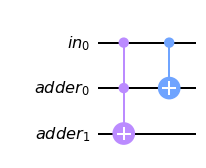

In [3]:
def concept_add_once(qc, qin, qadder):
    qc.ccx(qin[0], qadder[0], qadder[1])
    qc.cx(qin[0], qadder[0])
        
qin = QuantumRegister(1, 'in')
qadder = QuantumRegister(2, 'adder')
qc = QuantumCircuit(qin, qadder)
concept_add_once(qc, qin, qadder)
display_circuit(qc)

Now we need to repeat that for each input bit.

The following concept solution assumes that $\text{anc}_0$ represents least significant bit and $\text{anc}_1$ is the second least significant bit of the sum. After computation the latter is CX-ed to an answer qubit and the whole computation is undone. The following circuit represents this main concept.

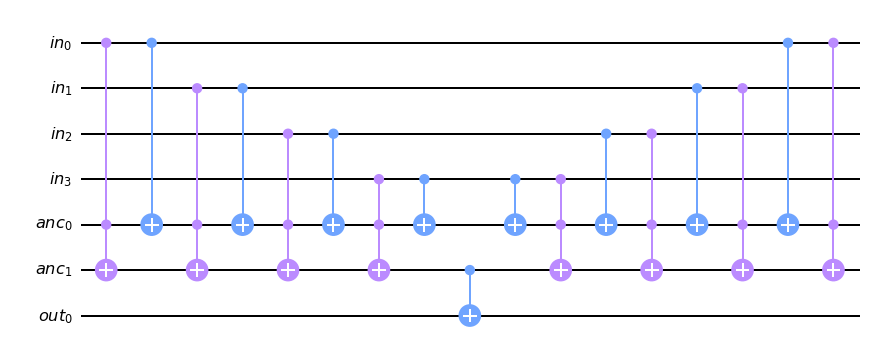

In [4]:
def concept_adder(qc, qin, qout, qanc):
    for i in range(4):
        qc.ccx(qin[i], qanc[0], qanc[1])
        qc.cx(qin[i], qanc[0])
        
    qc.barrier()
    qc.cx(qanc[1], qout[0])
    qc.barrier()
    
    for i in reversed(range(4)):
        qc.cx(qin[i], qanc[0])
        qc.ccx(qin[i], qanc[0], qanc[1])
    
qin = QuantumRegister(4, 'in')
qanc = QuantumRegister(2, 'anc')
qout = QuantumRegister(1, 'out')
qc = QuantumCircuit(qin, qanc, qout)
concept_adder(qc, qin, qout, qanc)
display_circuit(qc)

Now observe that we don't need to use $\text{anc}_1$ as we can directly compute the second least significant bit into $\text{out}_0$. But in this case we are still required to uncompute $\text{anc}_0$. Observe that since it is the least significant bit of the sum, it can be also interpreted as a xor of all input bits. We can then easily uncompute that bit by CX-ing all the input bits, so that the $\text{anc}_0$ is left in the $\ket0$ state in the end, regardless of the input configuration.

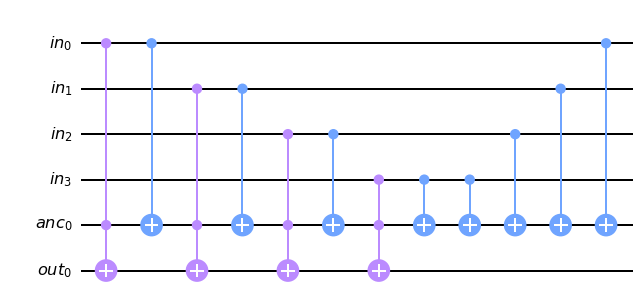

In [5]:
def concept_noanc1(qc, qin, qout, qanc):
    for i in range(4):
        qc.ccx(qin[i], qanc[0], qout[0])
        qc.cx(qin[i], qanc[0])
        
    qc.barrier()
    
    for i in reversed(range(4)):
        qc.cx(qin[i], qanc[0])
    
qin = QuantumRegister(4, 'in')
qanc = QuantumRegister(1, 'anc')
qout = QuantumRegister(1, 'out')
qc = QuantumCircuit(qin, qanc, qout)
concept_noanc1(qc, qin, qout, qanc)
display_circuit(qc)

We can remove the second ancilla as well. We can reinterpret temporarily the $\text{in}_3$ as the least significant bit of our sum. Naturaly, in the beginning this bit itself represents one-element sum – the 3rd summand. We only need to add to it the remaining three input bits. Uncomputing is also one CX shorter.

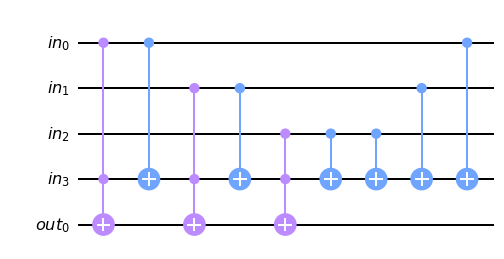

In [6]:
def concept_noanc2(qc, qin, qout):
    for i in range(3):
        qc.ccx(qin[i], qin[3], qout[0])
        qc.cx(qin[i], qin[3])
        
    qc.barrier()
    
    for i in reversed(range(3)):
        qc.cx(qin[i], qin[3])
    
qin = QuantumRegister(4, 'in')
qout = QuantumRegister(1, 'out')
qc = QuantumCircuit(qin, qout)
concept_noanc2(qc, qin, qout)
display_circuit(qc)

Now we can cancel the two CX-es that have annoyed us from the beginning of this analysis to finalize our solution concept.

In [7]:
def concept(qc, qin, qout):
    for i in range(3):
        qc.ccx(qin[i], qin[3], qout[0])
        if i < 3-1:
            qc.cx(qin[i], qin[3])
    
    for i in reversed(range(3-1)):
        qc.cx(qin[i], qin[3])

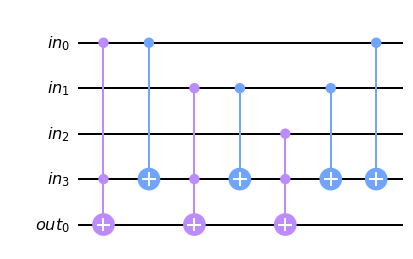

In [8]:
qin = QuantumRegister(4, 'in')
qout = QuantumRegister(1, 'out')
qc = QuantumCircuit(qin, qout)
concept(qc, qin, qout)
display_circuit(qc)

## Gate synthesis and optimization

In this excercies we can use CX and 1-qubit gates only. Relying on the transpiler is not enough to get the best solution, so let us do the gate synthesis manually.

### RCCX

Recall the `RCCX` gate, that acts similarly as the `CCX` gate, but adds some phase depending on the input values. In our case it is acceptable, as the final solution must be accurate up to the phase only. This gate is easily available in Qiskit (`RCCXGate`).

This gate is not symmetrical with respect to control qubits, so there are two possibilities it can replace `CCX`. Here we present its definition.

In [9]:
def rccx(qc, qc0, qc1, qt):
    qc.h(qt); qc.t(qt)
    qc.cx(qc0, qt)
    qc.tdg(qt)
    qc.cx(qc1, qt)
    qc.t(qt)
    qc.cx(qc0, qt)
    qc.tdg(qt); qc.h(qt)

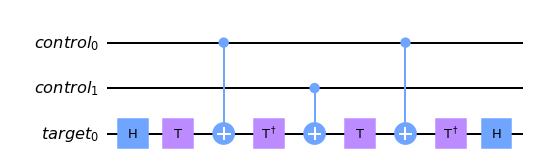

In [10]:
qco = QuantumRegister(2, 'control')
qta = QuantumRegister(1, 'target')
qc = QuantumCircuit(qco, qta)
rccx(qc, 0, 1, 2)
display_circuit(qc)

Recall our concept solution.

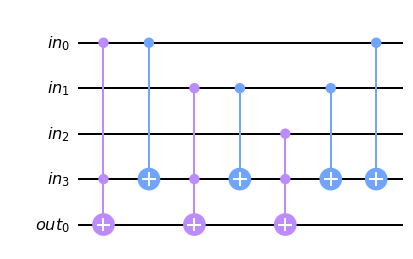

In [11]:
def concept_ccx(qc, qin, qout):
    qc.ccx(qin[0], qin[3], qout[0])
    qc.cx(qin[0], qin[3])
    qc.ccx(qin[1], qin[3], qout[0])
    qc.cx(qin[1], qin[3])
    qc.ccx(qin[2], qin[3], qout[0])
    qc.cx(qin[1], qin[3])
    qc.cx(qin[0], qin[3])
    
qin = QuantumRegister(4, 'in')
qout = QuantumRegister(1, 'out')
qc = QuantumCircuit(qin, qout)
concept_ccx(qc, qin, qout)
display_circuit(qc)

Let us now substitute the last `CCX` with `RCCX`. Note that the way we are doing it is more like trial and error method, but good point to start with is to replace all three `CCX`es consistently, which we will do in a moment.

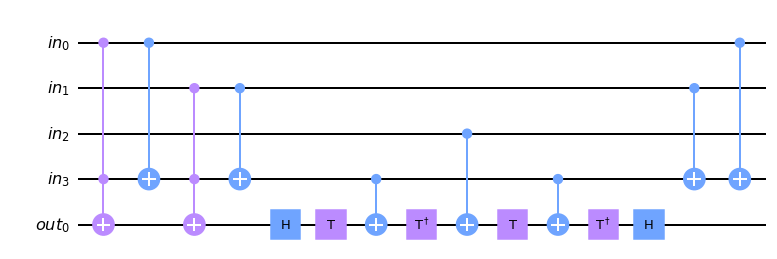

In [12]:
def concept_rccx1(qc, qin, qout):
    qc.ccx(qin[0], qin[3], qout[0])
    qc.cx(qin[0], qin[3])
    qc.ccx(qin[1], qin[3], qout[0])
    qc.cx(qin[1], qin[3])
    qc.barrier()
    rccx(qc, qin[3], qin[2], qout[0])
    qc.barrier()
    qc.cx(qin[1], qin[3])
    qc.cx(qin[0], qin[3])
    
qin = QuantumRegister(4, 'in')
qout = QuantumRegister(1, 'out')
qc = QuantumCircuit(qin, qout)
concept_rccx1(qc, qin, qout)
display_circuit(qc)

### 4-CX identity

Now let us look closely on `CX`-es on pairs $\text{in}_1$-$\text{in}_3$ and $\text{in}_3$-$\text{out}_0$. Their pattern looks like following one.

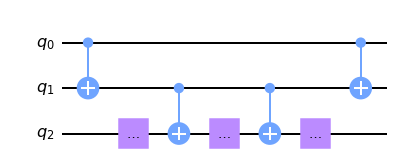

In [13]:
dummy = QuantumCircuit(1, name='…')

def extract_cx(qc):
    qc.cx(0, 1)
    qc.barrier()
    qc.append(dummy, [2])
    qc.cx(1, 2)
    qc.append(dummy, [2])
    qc.cx(1, 2)
    qc.append(dummy, [2])
    qc.barrier()
    qc.cx(0, 1)
    
qc = QuantumCircuit(3)
extract_cx(qc)
display_circuit(qc)

Observe that the first `CX` makes $\text{q}_1$ represent $\text{q}_0 \oplus \text{q}_1$ until it is eventually uncomputed at the end of this subcircuit. The middle `CX`-es could be therefore replaced by two `CX`-es each, while keeping $\text{q}_1$ unmodified:

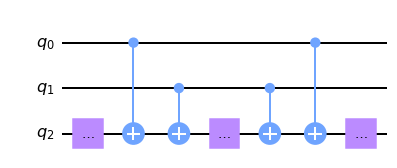

In [14]:
def extract_cx_equivalent(qc):
    qc.barrier()
    qc.append(dummy, [2])
    qc.cx(0, 2)
    qc.cx(1, 2)
    qc.append(dummy, [2])
    qc.cx(1, 2)
    qc.cx(0, 2)
    qc.append(dummy, [2])
    qc.barrier()
    
qc = QuantumCircuit(3)
extract_cx_equivalent(qc)
display_circuit(qc)

And now let us apply the above equivalence to our circuit:

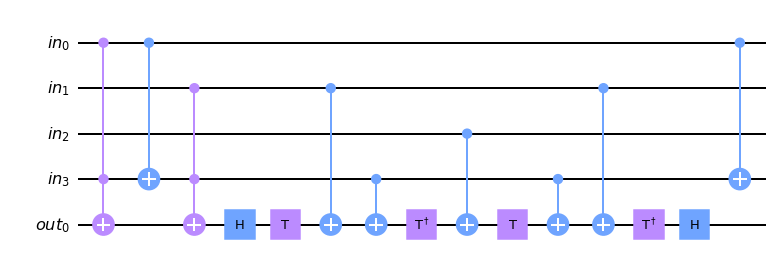

In [15]:
def concept_rccx1b(qc, qin, qout):
    qc.ccx(qin[0], qin[3], qout[0])
    qc.cx(qin[0], qin[3])
    qc.ccx(qin[1], qin[3], qout[0])
    
    qc.barrier()
    qc.h(qout[0]); qc.t(qout[0])
    qc.cx(qin[1], qout[0])
    qc.cx(qin[3], qout[0])
    qc.tdg(qout[0])
    qc.cx(qin[2], qout[0])
    qc.t(qout[0])
    qc.cx(qin[3], qout[0])
    qc.cx(qin[1], qout[0])
    qc.tdg(qout[0]); qc.h(qout[0])
    qc.barrier()
    
    qc.cx(qin[0], qin[3])
    
qin = QuantumRegister(4, 'in')
qout = QuantumRegister(1, 'out')
qc = QuantumCircuit(qin, qout)
concept_rccx1b(qc, qin, qout)
display_circuit(qc)

Next we replace the second `CCX` with `RCCX`, similarly like we have done before.

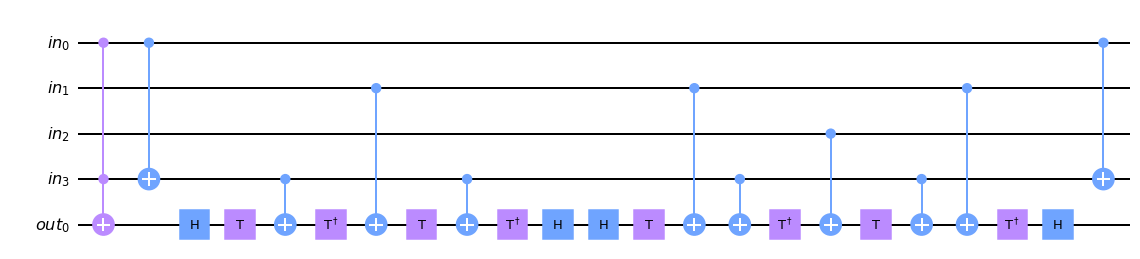

In [16]:
def concept_rccx2(qc, qin, qout):
    qc.ccx(qin[0], qin[3], qout[0])
    qc.cx(qin[0], qin[3])
    
    qc.barrier()
    rccx(qc, qin[3], qin[1], qout[0])
    
    qc.h(qout[0]); qc.t(qout[0])
    qc.cx(qin[1], qout[0])
    qc.cx(qin[3], qout[0])
    qc.tdg(qout[0])
    qc.cx(qin[2], qout[0])
    qc.t(qout[0])
    qc.cx(qin[3], qout[0])
    qc.cx(qin[1], qout[0])
    qc.tdg(qout[0]); qc.h(qout[0])
    qc.barrier()
    
    qc.cx(qin[0], qin[3])
    
qin = QuantumRegister(4, 'in')
qout = QuantumRegister(1, 'out')
qc = QuantumCircuit(qin, qout)
concept_rccx2(qc, qin, qout)
display_circuit(qc)

Note here that we ended up with application of the following operator $T H H T^\dagger$, which is effectively an identity. And applying simple commutation laws on `CX`-es around, we can cancel the pair of $\text{in}_3$-$\text{out}_0$ `CX`-es. Here is a simplified circuit:

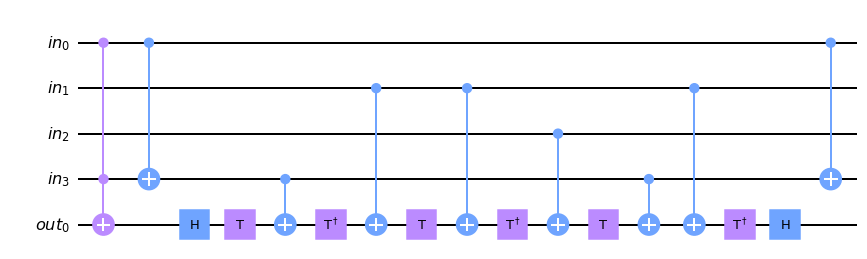

In [17]:
def concept_rccx2b(qc, qin, qout):
    qc.ccx(qin[0], qin[3], qout[0])
    qc.cx(qin[0], qin[3])
    
    qc.barrier()
    qc.h(qout[0]); qc.t(qout[0])
    qc.cx(qin[3], qout[0])
    qc.tdg(qout[0])
    qc.cx(qin[1], qout[0])
    qc.t(qout[0])
    qc.cx(qin[1], qout[0])
    qc.tdg(qout[0])
    qc.cx(qin[2], qout[0])
    qc.t(qout[0])
    qc.cx(qin[3], qout[0])
    qc.cx(qin[1], qout[0])
    qc.tdg(qout[0]); qc.h(qout[0])
    qc.barrier()
    
    qc.cx(qin[0], qin[3])
    
qin = QuantumRegister(4, 'in')
qout = QuantumRegister(1, 'out')
qc = QuantumCircuit(qin, qout)
concept_rccx2b(qc, qin, qout)
display_circuit(qc)

Now we can apply again the 4-CX equivalence we discussed earlier on pairs $\text{in}_0$-$\text{in}_3$ and $\text{in}_3$-$\text{out}_0$

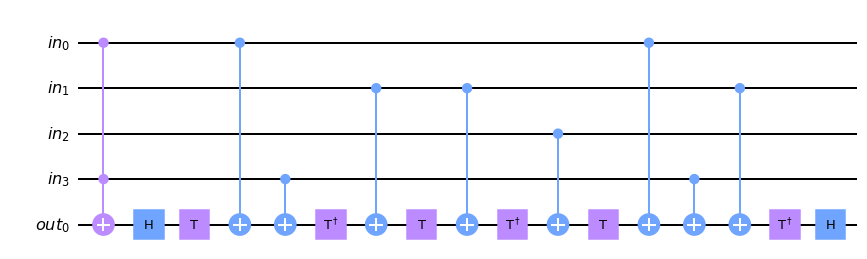

In [18]:
def concept_rccx2c(qc, qin, qout):
    qc.ccx(qin[0], qin[3], qout[0])
    
    qc.barrier()
    qc.h(qout[0]); qc.t(qout[0])
    qc.cx(qin[0], qout[0])
    qc.cx(qin[3], qout[0])
    qc.tdg(qout[0])
    qc.cx(qin[1], qout[0])
    qc.t(qout[0])
    qc.cx(qin[1], qout[0])
    qc.tdg(qout[0])
    qc.cx(qin[2], qout[0])
    qc.t(qout[0])
    qc.cx(qin[0], qout[0])
    qc.cx(qin[3], qout[0])
    qc.cx(qin[1], qout[0])
    qc.tdg(qout[0]); qc.h(qout[0])
    
qin = QuantumRegister(4, 'in')
qout = QuantumRegister(1, 'out')
qc = QuantumCircuit(qin, qout)
concept_rccx2c(qc, qin, qout)
display_circuit(qc)

Quite predictably, we continue by replacing the remaining `CCX` with `RCCX`.

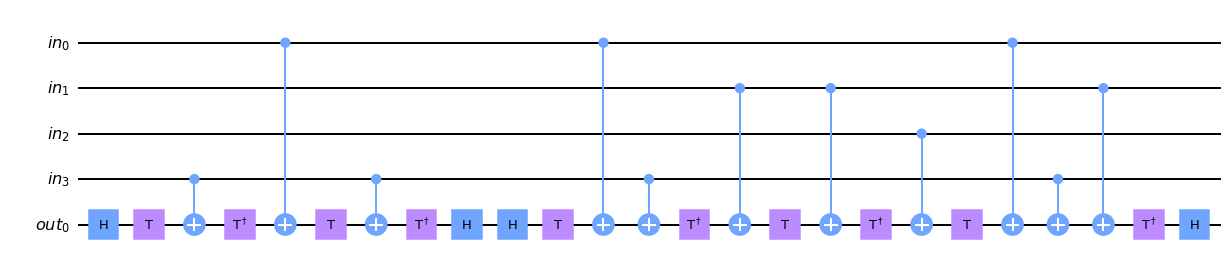

In [19]:
def concept_rccx3(qc, qin, qout):
    rccx(qc, qin[3], qin[0], qout[0])
    
    qc.barrier()
    qc.h(qout[0]); qc.t(qout[0])
    qc.cx(qin[0], qout[0])
    qc.cx(qin[3], qout[0])
    qc.tdg(qout[0])
    qc.cx(qin[1], qout[0])
    qc.t(qout[0])
    qc.cx(qin[1], qout[0])
    qc.tdg(qout[0])
    qc.cx(qin[2], qout[0])
    qc.t(qout[0])
    qc.cx(qin[0], qout[0])
    qc.cx(qin[3], qout[0])
    qc.cx(qin[1], qout[0])
    qc.tdg(qout[0]); qc.h(qout[0])
    
qin = QuantumRegister(4, 'in')
qout = QuantumRegister(1, 'out')
qc = QuantumCircuit(qin, qout)
concept_rccx3(qc, qin, qout)
display_circuit(qc)

Familiar simplifications lead us to the following circuit.

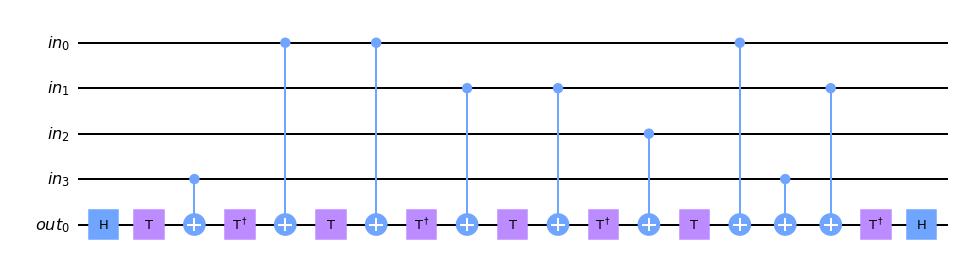

In [20]:
def concept_rccx3b(qc, qin, qout):
    qc.h(qout[0]); qc.t(qout[0])
    qc.cx(qin[3], qout[0])
    qc.tdg(qout[0])
    qc.cx(qin[0], qout[0])
    qc.t(qout[0])
    qc.cx(qin[0], qout[0])
    qc.tdg(qout[0])
    qc.cx(qin[1], qout[0])
    qc.t(qout[0])
    qc.cx(qin[1], qout[0])
    qc.tdg(qout[0])
    qc.cx(qin[2], qout[0])
    qc.t(qout[0])
    qc.cx(qin[0], qout[0])
    qc.cx(qin[3], qout[0])
    qc.cx(qin[1], qout[0])
    qc.tdg(qout[0]); qc.h(qout[0])
    
qin = QuantumRegister(4, 'in')
qout = QuantumRegister(1, 'out')
qc = QuantumCircuit(qin, qout)
concept_rccx3b(qc, qin, qout)
display_circuit(qc)

### Improving further

Our circuit now has only 9 `CX` gates. None of them can be parallelized, so the circuit cost is now 18. As this is still to far from 12, we need to improve it further.

Let us observe the following subcircuit:

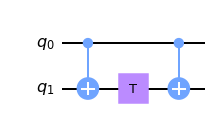

In [21]:
def diagonal(qc):
    qc.cx(0, 1)
    qc.t(1)
    qc.cx(0, 1)
        
qc = QuantumCircuit(2)
diagonal(qc)
display_circuit(qc)

This represents diagonal operation! In fact, if instead of `T` gate, we put any diagonal gate, it still results in diagonal operation. Diagonal operations commute with each other, so we can rearrange some `T` gates in the circuit above.

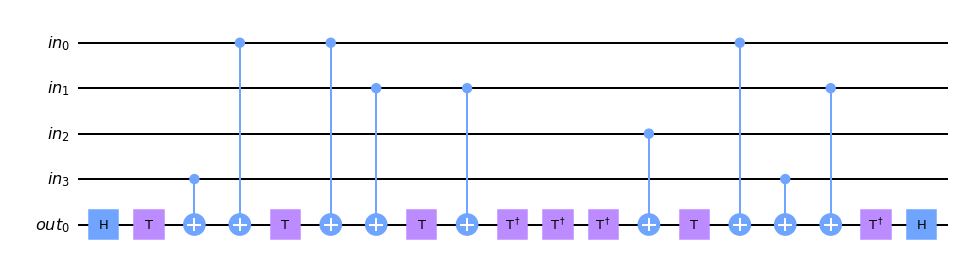

In [22]:
def concept_rccx3c(qc, qin, qout):
    qc.h(qout[0]); qc.t(qout[0])
    qc.cx(qin[3], qout[0])
    qc.cx(qin[0], qout[0])
    qc.t(qout[0])
    qc.cx(qin[0], qout[0])
    qc.cx(qin[1], qout[0])
    qc.t(qout[0])
    qc.cx(qin[1], qout[0])
    qc.tdg(qout[0]); qc.tdg(qout[0]); qc.tdg(qout[0])
    qc.cx(qin[2], qout[0])
    qc.t(qout[0])
    qc.cx(qin[0], qout[0])
    qc.cx(qin[3], qout[0])
    qc.cx(qin[1], qout[0])
    qc.tdg(qout[0]); qc.h(qout[0])
    
qin = QuantumRegister(4, 'in')
qout = QuantumRegister(1, 'out')
qc = QuantumCircuit(qin, qout)
concept_rccx3c(qc, qin, qout)
display_circuit(qc)

Not much changed regarding our cost. But now we can apply the reverse of the 4-CX equivalence to minimize the 2-qubit circuit depth, giving us final 16-cost solution.

In [23]:
def solution(qc, qin, qout):
    qc.h(qout[0]); qc.t(qout[0])
    qc.cx(qin[0], qout[0])
    qc.cx(qin[3], qout[0])
    qc.cx(qin[1], qin[0])
    qc.t(qout[0])
    qc.cx(qin[0], qout[0])
    qc.t(qout[0])
    qc.cx(qin[1], qout[0])
    qc.tdg(qout[0]); qc.tdg(qout[0]); qc.tdg(qout[0])
    qc.cx(qin[2], qout[0])
    qc.t(qout[0])
    qc.cx(qin[0], qout[0])
    qc.cx(qin[3], qout[0])
    qc.cx(qin[1], qin[0])
    qc.tdg(qout[0]); qc.h(qout[0])

In the circuit diagram below it can be clearly seen which `CX` can be parallelized. The solution has still 9 `CX` gates, but only `7` time moments.

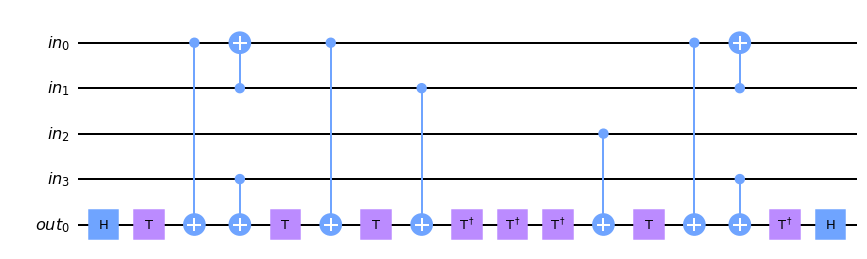

In [24]:
qin = QuantumRegister(4, 'in')
qout = QuantumRegister(1, 'out')
qc = QuantumCircuit(qin, qout)
solution(qc, qin, qout)
display_circuit(qc)

### Testing the solution
To verify its correctness, let us examine circuit's unitary. We observe that it works just right – the output bit is changed when the popcount is either 2 or 3. In addition, some phase might be added, but that is compliant with the requirements for this task.

In [25]:
U = get_unitary(qc)

def fmt_state(i: int) -> str:
    return f'|{i//2:04b},{i&1:01b}>'

def fmt_number_mul(x: complex) -> str:
    for v, s in [(1, ''), (1j, 'i'), (-1j, '-i'), (-1, '-')]:
        if abs(v-x) < 1e-5: return s
    return str(x)

for fr in range(U.shape[1]):
    if fr & 1: continue
    print(f'{fmt_state(fr)} ->', end=' ')
    for to in range(U.shape[0]):
        if abs(U[to, fr]) > 1e-5:
            print(f'{fmt_number_mul(U[to, fr]):>2}{fmt_state(to)} ')

|0000,0> ->   |0000,0> 
|0001,0> ->   |0001,0> 
|0010,0> ->   |0010,0> 
|0011,0> ->  i|0011,1> 
|0100,0> ->   |0100,0> 
|0101,0> ->  i|0101,1> 
|0110,0> ->  i|0110,1> 
|0111,0> -> -i|0111,1> 
|1000,0> ->   |1000,0> 
|1001,0> ->  i|1001,1> 
|1010,0> ->  i|1010,1> 
|1011,0> -> -i|1011,1> 
|1100,0> ->  i|1100,1> 
|1101,0> -> -i|1101,1> 
|1110,0> -> -i|1110,1> 
|1111,0> ->  -|1111,0> 


## Closing words

This write-up presents the algorithm used for my contest submission.

At [BEIT](https://beit.tech) we recognize the importance of optimizing even small subcircuits with regard to gate count or the circuit depth as it greatly affects the circuit fidelity.
We published two papers on our experimental results on the unstructured search utilizing optimization techniques of similar rank, see:

- [4-qubit search on the IBM's machine](publications/ibm-benchmarking.html)
- [4,5,6-qubit search on the Honeywell's machine](publications/honeywell-unstructured-search.html)